In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model


# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [3]:
dataset = "/Users/gracegu/Desktop/Uchicago/machine learning/project/Bag Classes"
walk_through_dir(dataset)

There are 3 directories and 1 images in '/Users/gracegu/Desktop/Uchicago/machine learning/project/Bag Classes'.
There are 0 directories and 5000 images in '/Users/gracegu/Desktop/Uchicago/machine learning/project/Bag Classes/Garbage Bag Images'.
There are 0 directories and 5000 images in '/Users/gracegu/Desktop/Uchicago/machine learning/project/Bag Classes/Paper Bag Images'.
There are 0 directories and 5000 images in '/Users/gracegu/Desktop/Uchicago/machine learning/project/Bag Classes/Plastic Bag Images'.


In [4]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
image_df

Filepath               Label
0      /Users/gracegu/Desktop/Uchicago/machine learni...  Garbage Bag Images
1      /Users/gracegu/Desktop/Uchicago/machine learni...  Garbage Bag Images
2      /Users/gracegu/Desktop/Uchicago/machine learni...  Garbage Bag Images
3      /Users/gracegu/Desktop/Uchicago/machine learni...  Garbage Bag Images
4      /Users/gracegu/Desktop/Uchicago/machine learni...  Garbage Bag Images
...                                                  ...                 ...
14995  /Users/gracegu/Desktop/Uchicago/machine learni...  Plastic Bag Images
14996  /Users/gracegu/Desktop/Uchicago/machine learni...  Plastic Bag Images
14997  /Users/gracegu/Desktop/Uchicago/machine learni...  Plastic Bag Images
14998  /Users/gracegu/Desktop/Uchicago/machine learni...  Plastic Bag Images
14999  /Users/gracegu/Desktop/Uchicago/machine learni...  Plastic Bag Images

[15000 rows x 2 columns]

[10930 11923  7308  3992  9870  4619  2525  2501  7250 14845 10228  6729
  4798  1633  1107  9254]


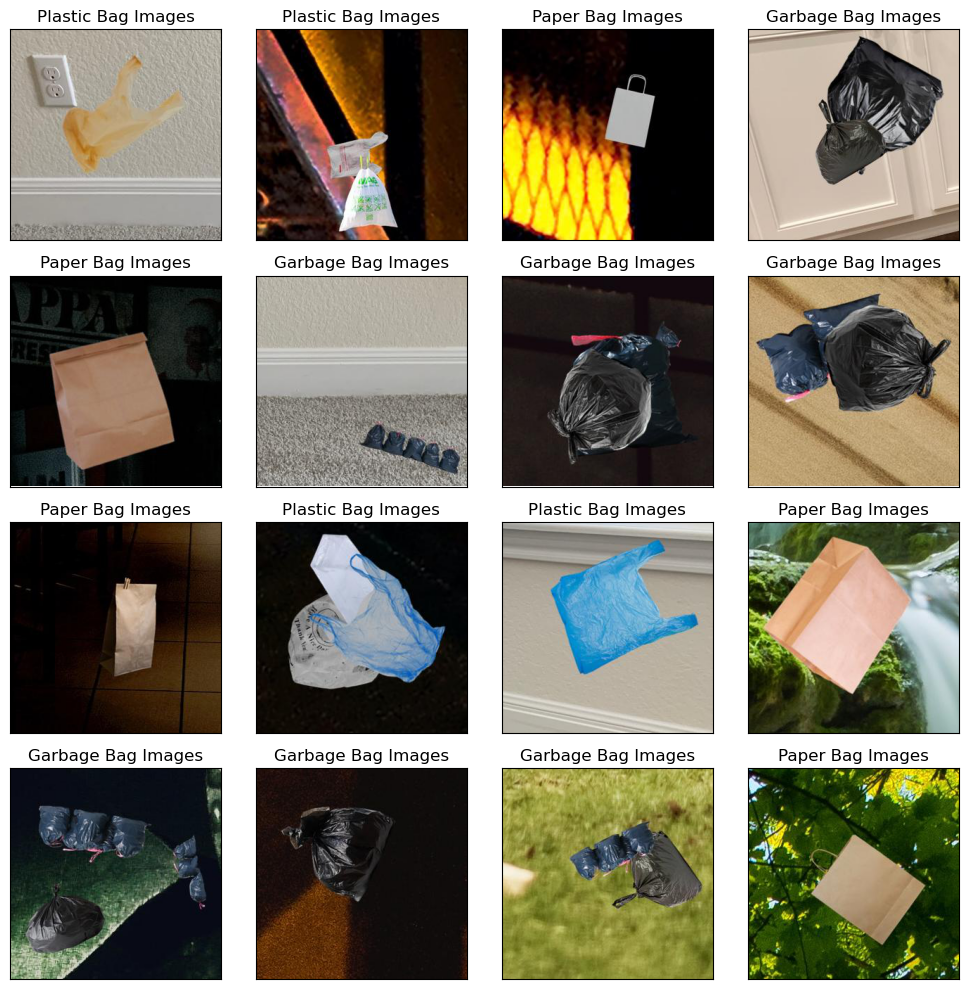

In [6]:
random_index = np.random.randint(0, len(image_df), 16)
print(random_index)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [7]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [8]:
train_df.shape

(12000, 2)

In [9]:
test_df.shape

(3000, 2)

In [10]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [11]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [12]:
# Split the data into three categories.
train_images = train_generator.flow_from_directory(
    dataset,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_images = train_generator.flow_from_directory(
    dataset,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


In [13]:
#Loading pretrained model

# pretrained_model=tf.keras.applications.ResNet50(
#         input_shape=(224, 224, 3),
#         include_top=False,
#         weights='imagenet',
#         pooling='avg'
# )

In [14]:
# pretrained_model.trainable = False

In [15]:
# Create checkpoint callback
checkpoint_path = "bags_classification_model_checkpoint.weights.h5"  # Updated file path
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [16]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [18]:
# Define model architecture using ResNet50
pretrained_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
pretrained_model.trainable = False  # Freeze the base model

In [19]:
# Define model architecture using ResNet50
inputs = pretrained_model.input
x = layers.GlobalAveragePooling2D()(pretrained_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(3, activation='softmax')(x)

In [20]:
model=Model(inputs,outputs)

In [21]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [23]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_images,
    steps_per_epoch=train_images.samples // train_images.batch_size,
    validation_data=val_images,
    validation_steps=val_images.samples // val_images.batch_size,
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "bag_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/bag_classification/20240522-230749
Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 284s 752ms/step - accuracy: 0.9790 - loss: 0.0615 - val_accuracy: 0.9889 - val_loss: 0.0375
Epoch 2/100


2024-05-22 23:12:33.297811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 3/100


2024-05-22 23:12:33.774178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


375/375 ━━━━━━━━━━━━━━━━━━━━ 290s 772ms/step - accuracy: 0.9887 - loss: 0.0323 - val_accuracy: 0.9892 - val_loss: 0.0323
Epoch 4/100


2024-05-22 23:17:23.513318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 6.9338e-04
Epoch 5/100


2024-05-22 23:17:23.985647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


375/375 ━━━━━━━━━━━━━━━━━━━━ 288s 768ms/step - accuracy: 0.9929 - loss: 0.0187 - val_accuracy: 0.9892 - val_loss: 0.0306
Epoch 6/100


2024-05-22 23:22:12.257210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9583 - val_loss: 0.0508
Epoch 7/100


2024-05-22 23:22:12.746982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


375/375 ━━━━━━━━━━━━━━━━━━━━ 284s 757ms/step - accuracy: 0.9944 - loss: 0.0160 - val_accuracy: 0.9882 - val_loss: 0.0289
Epoch 8/100


2024-05-22 23:26:56.671081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0167
Epoch 9/100


2024-05-22 23:26:57.145822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


375/375 ━━━━━━━━━━━━━━━━━━━━ 282s 752ms/step - accuracy: 0.9952 - loss: 0.0119 - val_accuracy: 0.9913 - val_loss: 0.0215


In [24]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.01648
Test Accuracy: 99.63%


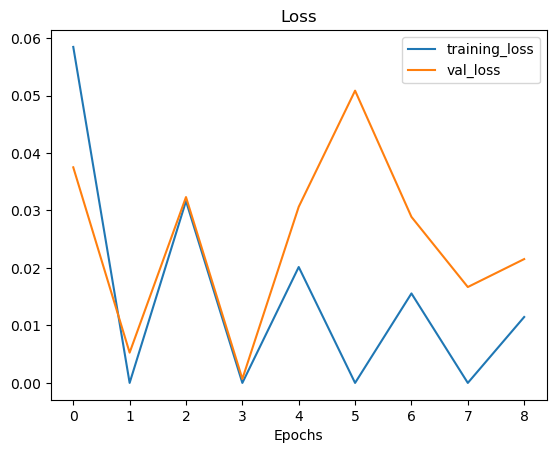

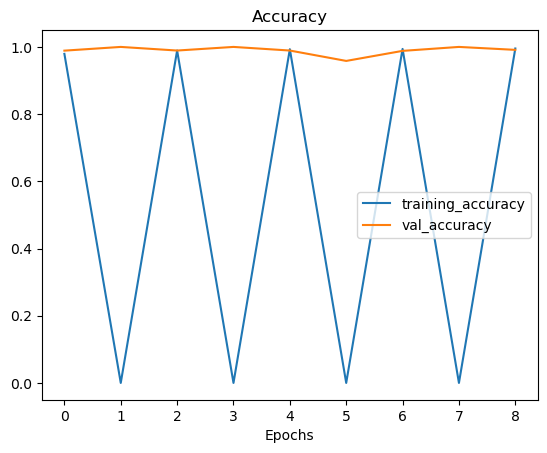

In [25]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [26]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 597ms/step


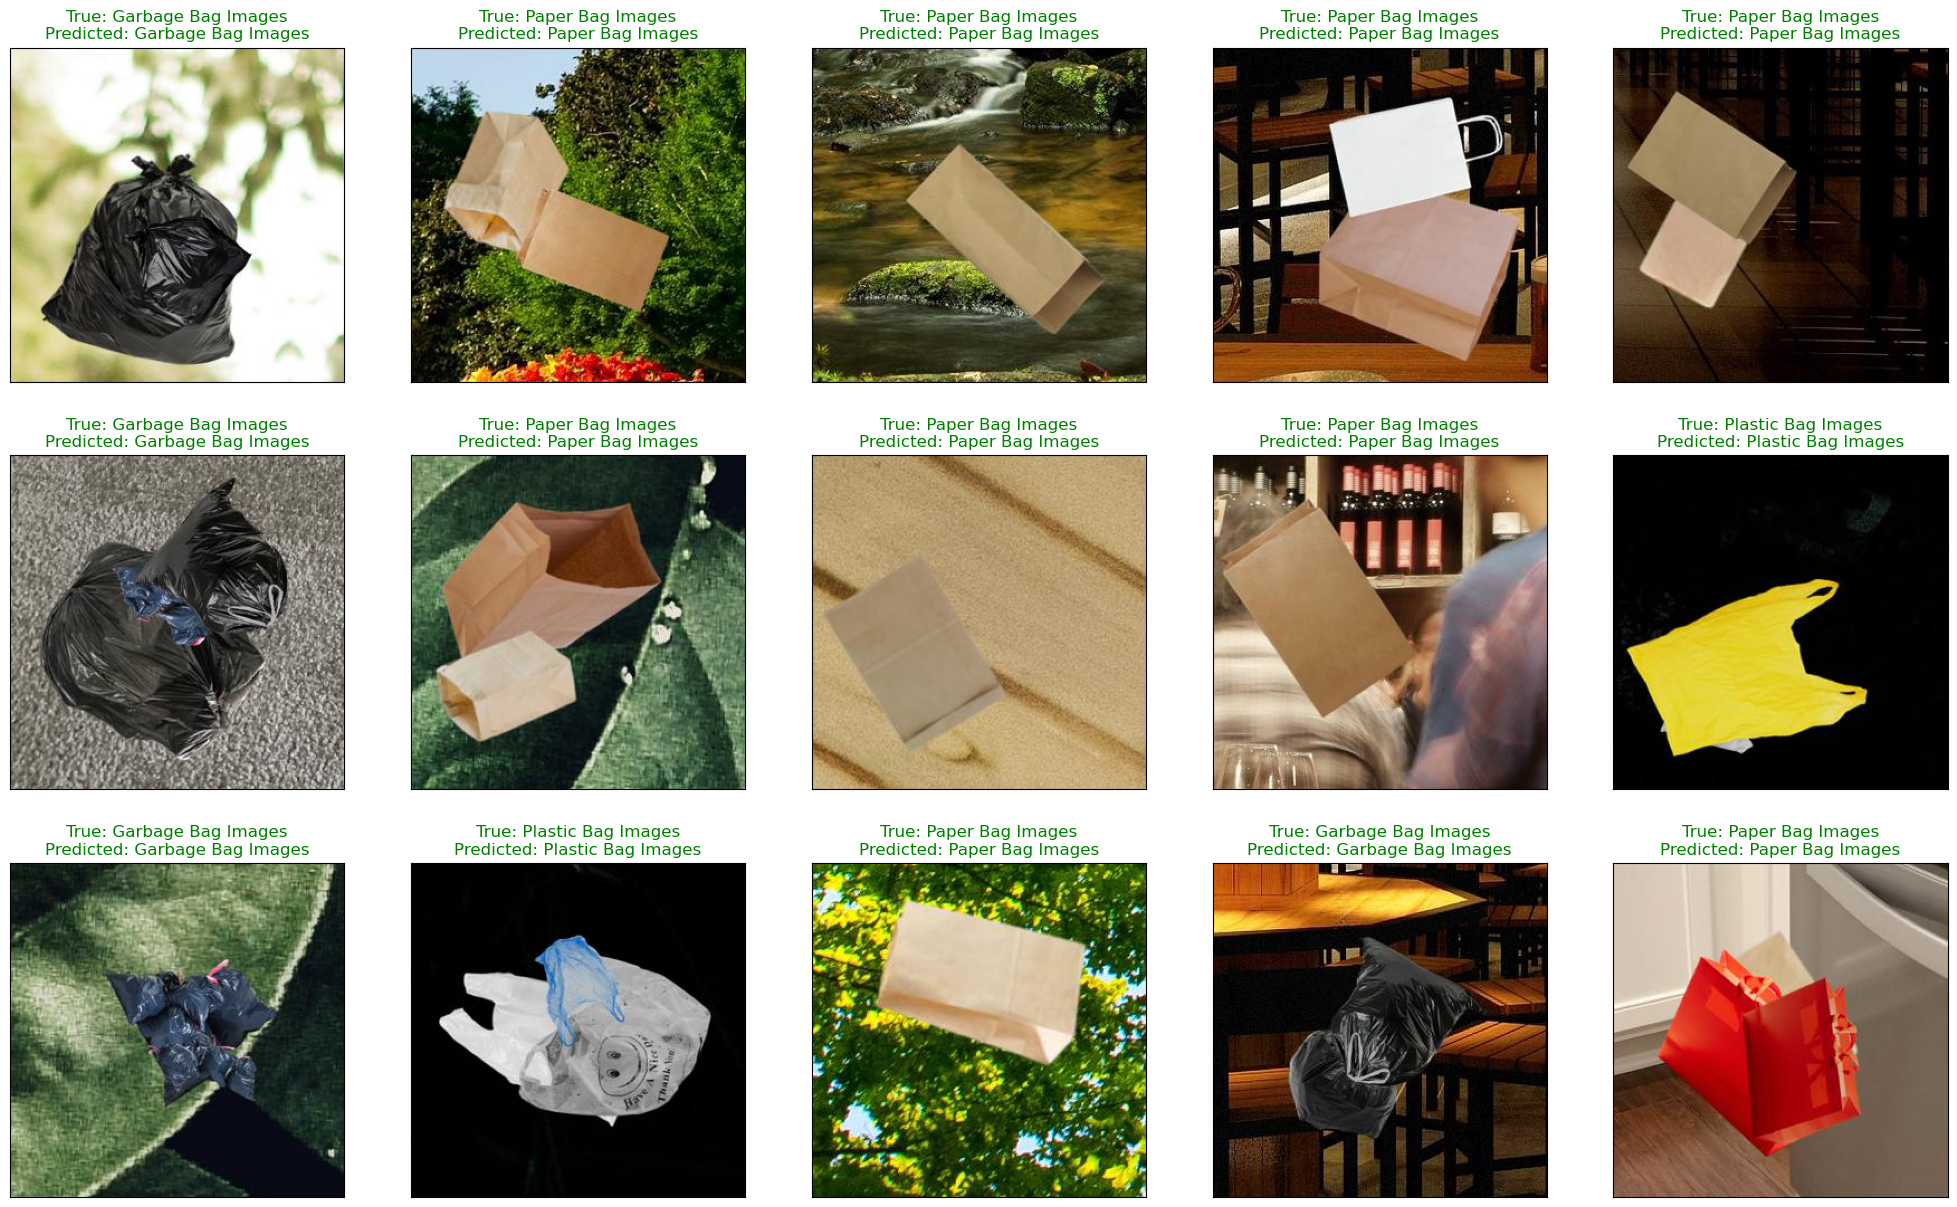

<Figure size 640x480 with 0 Axes>

In [27]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [28]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
Garbage Bag Images   0.999036  0.999036  0.999036  1037.000000
Paper Bag Images     1.000000  0.990722  0.995339   970.000000
Plastic Bag Images   0.990020  0.998993  0.994486   993.000000
accuracy             0.996333  0.996333  0.996333     0.996333
macro avg            0.996352  0.996250  0.996287  3000.000000
weighted avg         0.996363  0.996333  0.996335  3000.000000